In [3]:
import pandas as pd
import os

csv_path = "/kaggle/input/contrast-enhanced-ham10k/HAM10000_metadata.csv"
image_dir = "/kaggle/input/contrast-enhanced-ham10k/processed_images_after_CE-20250703T161112Z-1-001/processed_images_after_CE"

df = pd.read_csv(csv_path)
df["filename"] = df["image_id"] + ".jpg"

available_images = set(os.listdir(image_dir))
df = df[df["filename"].isin(available_images)]

print(f"✅ Matched {len(df)} images with labels.")
print(df[["filename", "dx"]].head())


✅ Matched 10015 images with labels.
           filename   dx
0  ISIC_0027419.jpg  bkl
1  ISIC_0025030.jpg  bkl
2  ISIC_0026769.jpg  bkl
3  ISIC_0025661.jpg  bkl
4  ISIC_0031633.jpg  bkl


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1
)

train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col="filename",
    y_col="dx",
    subset="training",
    target_size=img_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col="filename",
    y_col="dx",
    subset="validation",
    target_size=img_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

num_classes = len(train_gen.class_indices)


2025-07-16 18:39:24.930404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752691165.115038      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752691165.174973      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [5]:
import pandas as pd

csv_path = "/kaggle/input/contrast-enhanced-ham10k/HAM10000_metadata.csv"
df = pd.read_csv(csv_path)

# Add filename
df["filename"] = df["image_id"] + ".jpg"

# Count class samples
class_counts = df["dx"].value_counts()
print("🔍 Class distribution:")
print(class_counts)


🔍 Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [6]:
import pandas as pd

csv_path = "/kaggle/input/contrast-enhanced-ham10k/HAM10000_metadata.csv"
df = pd.read_csv(csv_path)

# Add filename
df["filename"] = df["image_id"] + ".jpg"

# Count class samples
class_counts = df["dx"].value_counts()
print("🔍 Class distribution:")
print(class_counts)


🔍 Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [7]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tqdm import tqdm
import shutil
import pandas as pd

# Paths
image_dir = "/kaggle/input/contrast-enhanced-ham10k/processed_images_after_CE-20250703T161112Z-1-001/processed_images_after_CE"
augmented_dir = "/kaggle/working/balanced_data_augmented"
os.makedirs(augmented_dir, exist_ok=True)

# Load original metadata
csv_path = "/kaggle/input/contrast-enhanced-ham10k/HAM10000_metadata.csv"
df = pd.read_csv(csv_path)
df["filename"] = df["image_id"] + ".jpg"

# Filter only images that exist
available_images = set(os.listdir(image_dir))
df = df[df["filename"].isin(available_images)]

# Target count = max class size
target_count = df["dx"].value_counts().max()

# Define augmenter
augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

balanced_records = []

for label in df["dx"].unique():
    class_df = df[df["dx"] == label]
    num_existing = len(class_df)
    
    print(f"\n📦 Augmenting class '{label}': {num_existing} ➡ {target_count}")
    
    # Copy original images
    for _, row in class_df.iterrows():
        src = os.path.join(image_dir, row["filename"])
        dst = os.path.join(augmented_dir, row["filename"])
        shutil.copy(src, dst)
        balanced_records.append({"filename": row["filename"], "dx": label})

    # Augment to reach target
    extra_needed = target_count - num_existing
    if extra_needed <= 0:
        continue

    images_list = class_df["filename"].tolist()
    for i in tqdm(range(extra_needed)):
        img_name = images_list[i % num_existing]
        img_path = os.path.join(image_dir, img_name)

        img = load_img(img_path, target_size=(224, 224))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        for batch in augmenter.flow(x, batch_size=1):
            new_name = f"{label}_aug_{i}_{img_name}"
            save_img(os.path.join(augmented_dir, new_name), batch[0])
            balanced_records.append({"filename": new_name, "dx": label})
            break  # one augmented image per iteration



📦 Augmenting class 'bkl': 1099 ➡ 6705


100%|██████████| 5606/5606 [01:14<00:00, 75.30it/s]



📦 Augmenting class 'nv': 6705 ➡ 6705

📦 Augmenting class 'df': 115 ➡ 6705


100%|██████████| 6590/6590 [01:27<00:00, 75.73it/s]



📦 Augmenting class 'mel': 1113 ➡ 6705


100%|██████████| 5592/5592 [01:13<00:00, 75.91it/s]



📦 Augmenting class 'vasc': 142 ➡ 6705


100%|██████████| 6563/6563 [01:25<00:00, 76.55it/s]



📦 Augmenting class 'bcc': 514 ➡ 6705


100%|██████████| 6191/6191 [01:20<00:00, 77.08it/s]



📦 Augmenting class 'akiec': 327 ➡ 6705


100%|██████████| 6378/6378 [01:24<00:00, 75.89it/s]


In [8]:
df_balanced = pd.DataFrame(balanced_records)
df_balanced.to_csv("/kaggle/working/balanced_metadata.csv", index=False)

print("✅ CSV saved at: /kaggle/working/balanced_metadata.csv")
print(df_balanced["dx"].value_counts())


✅ CSV saved at: /kaggle/working/balanced_metadata.csv
dx
bkl      6705
nv       6705
df       6705
mel      6705
vasc     6705
bcc      6705
akiec    6705
Name: count, dtype: int64


In [9]:
import pandas as pd

# Load new metadata
df = pd.read_csv("/kaggle/working/balanced_metadata.csv")
print("✅ Balanced CSV loaded.")
print(df["dx"].value_counts())


✅ Balanced CSV loaded.
dx
bkl      6705
nv       6705
df       6705
mel      6705
vasc     6705
bcc      6705
akiec    6705
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split

# Split for training and validation
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["dx"],
    random_state=42
)

print("🧪 Training set class distribution:\n", train_df["dx"].value_counts())
print("\n🧪 Validation set class distribution:\n", val_df["dx"].value_counts())


🧪 Training set class distribution:
 dx
df       5364
nv       5364
bkl      5364
bcc      5364
mel      5364
akiec    5364
vasc     5364
Name: count, dtype: int64

🧪 Validation set class distribution:
 dx
bkl      1341
vasc     1341
bcc      1341
nv       1341
mel      1341
df       1341
akiec    1341
Name: count, dtype: int64


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32
image_dir = "/kaggle/working/balanced_data_augmented"

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col="filename",
    y_col="dx",
    target_size=img_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col="filename",
    y_col="dx",
    target_size=img_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

num_classes = len(train_gen.class_indices)


Found 37548 validated image filenames belonging to 7 classes.
Found 9387 validated image filenames belonging to 7 classes.


In [12]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


I0000 00:00:1752691749.343943      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1752691771.266896      98 service.cc:148] XLA service 0x78d608001690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752691771.267831      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752691773.919845      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1174 ━━━━━━━━━━━━━━━━━━━━ 1:01 52ms/step - accuracy: 0.1328 - loss: 2.5145   

I0000 00:00:1752691784.384949      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1174/1174 ━━━━━━━━━━━━━━━━━━━━ 133s 87ms/step - accuracy: 0.4240 - loss: 1.5444 - val_accuracy: 0.6224 - val_loss: 1.0240 - learning_rate: 0.0010
Epoch 2/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 83s 70ms/step - accuracy: 0.5651 - loss: 1.1507 - val_accuracy: 0.6455 - val_loss: 0.9653 - learning_rate: 0.0010
Epoch 3/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 70s 59ms/step - accuracy: 0.5730 - loss: 1.1311 - val_accuracy: 0.6572 - val_loss: 0.9430 - learning_rate: 0.0010
Epoch 4/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 70s 60ms/step - accuracy: 0.5739 - loss: 1.1244 - val_accuracy: 0.6629 - val_loss: 0.9279 - learning_rate: 0.0010
Epoch 5/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 68s 58ms/step - accuracy: 0.5793 - loss: 1.1124 - val_accuracy: 0.6610 - val_loss: 0.9260 - learning_rate: 0.0010
Epoch 6/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 70s 59ms/step - accuracy: 0.5812 - loss: 1.1119 - val_accuracy: 0.6591 - val_loss: 0.9216 - learning_rate: 0.0010
Epoch 7/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 71s 60ms/step - accuracy: 0.5760

In [14]:
# Unfreeze base model
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 478s 256ms/step - accuracy: 0.6893 - loss: 1.0324 - val_accuracy: 0.8859 - val_loss: 0.3243 - learning_rate: 1.0000e-04
Epoch 2/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 204s 174ms/step - accuracy: 0.9088 - loss: 0.2562 - val_accuracy: 0.9152 - val_loss: 0.2318 - learning_rate: 1.0000e-04
Epoch 3/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 204s 174ms/step - accuracy: 0.9495 - loss: 0.1451 - val_accuracy: 0.9048 - val_loss: 0.2786 - learning_rate: 1.0000e-04
Epoch 4/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 204s 174ms/step - accuracy: 0.9666 - loss: 0.0995 - val_accuracy: 0.9221 - val_loss: 0.2144 - learning_rate: 1.0000e-04
Epoch 5/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 204s 174ms/step - accuracy: 0.9752 - loss: 0.0710 - val_accuracy: 0.9344 - val_loss: 0.2216 - learning_rate: 1.0000e-04
Epoch 6/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 204s 174ms/step - accuracy: 0.9781 - loss: 0.0586 - val_accuracy: 0.9485 - val_loss: 0.1512 - learning_rate: 1.0000e-04
Epoch 7/10
1174/1174 ━━━━━━━

In [15]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

print("✅ Final Accuracy:", accuracy_score(y_true, y_pred))
print("\n🧾 Final Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(val_gen.class_indices.keys())))


294/294 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step
✅ Final Accuracy: 0.9854053478214552

🧾 Final Classification Report:

              precision    recall  f1-score   support

       akiec       0.99      1.00      0.99      1341
         bcc       0.99      1.00      1.00      1341
         bkl       0.98      0.97      0.98      1341
          df       1.00      1.00      1.00      1341
         mel       0.97      0.96      0.97      1341
          nv       0.96      0.96      0.96      1341
        vasc       1.00      1.00      1.00      1341

    accuracy                           0.99      9387
   macro avg       0.99      0.99      0.99      9387
weighted avg       0.99      0.99      0.99      9387



Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.


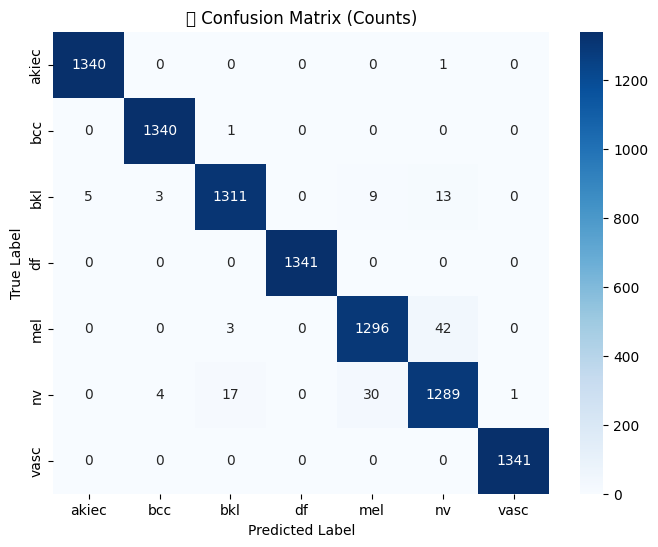

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(val_gen.class_indices.keys())

# Plot absolute values
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('🔍 Confusion Matrix (Counts)')
plt.show()


Glyph 128300 (\N{MICROSCOPE}) missing from current font.


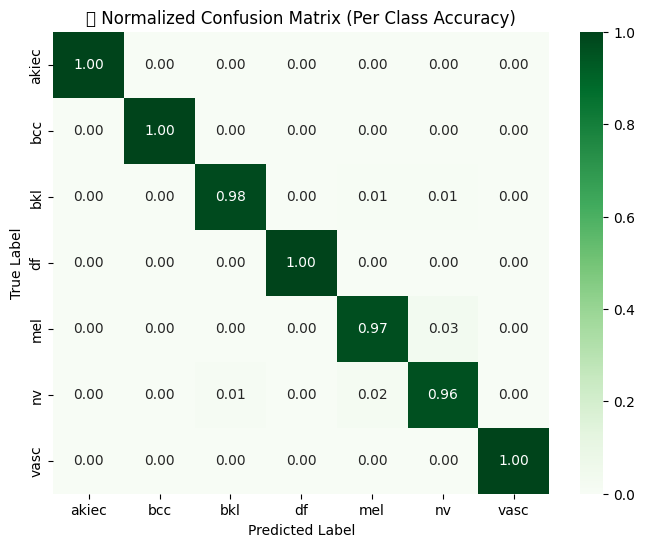

In [69]:
# Normalize by row (true labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('🔬 Normalized Confusion Matrix (Per Class Accuracy)')
plt.show()


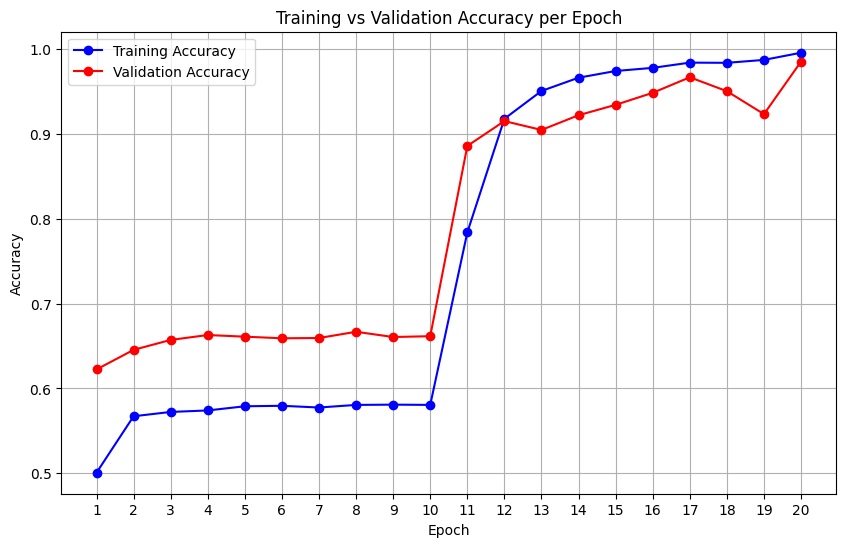

In [16]:
import matplotlib.pyplot as plt

# Combine training and fine-tuning accuracies
train_acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()


Explainable AI-GradCam

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [18]:
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    # Get model's last convolutional layer
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients of predicted class wrt conv output
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [19]:
def show_gradcam(image_path, model, last_conv_layer_name, preprocess=True):
    # Load & preprocess image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)

    if preprocess:
        img_array = img_array / 255.0

    input_array = np.expand_dims(img_array, axis=0)

    # Get predicted label
    preds = model.predict(input_array)
    pred_class = np.argmax(preds[0])
    class_label = list(train_gen.class_indices.keys())[pred_class]
    print(f"🔮 Predicted Class: {class_label} (Prob: {np.max(preds[0]):.2f})")

    # Grad-CAM
    heatmap = get_gradcam_heatmap(model, input_array, last_conv_layer_name)

    # Overlay heatmap
    heatmap_resized = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    overlayed_img = heatmap_color * 0.4 + np.array(img)

    # Show result
    plt.figure(figsize=(8, 6))
    plt.imshow(np.uint8(overlayed_img))
    plt.title(f"Grad-CAM: {class_label}")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
🔮 Predicted Class: vasc (Prob: 1.00)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


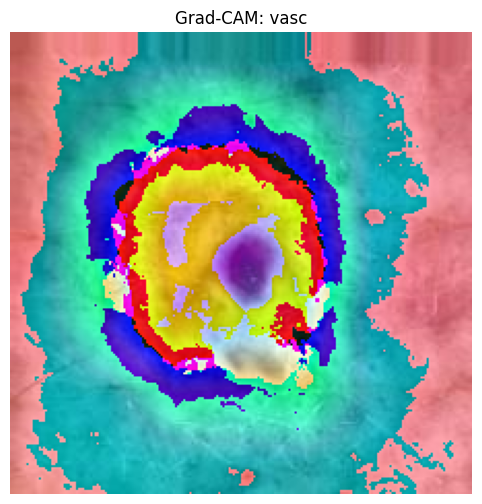

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
🔮 Predicted Class: akiec (Prob: 1.00)


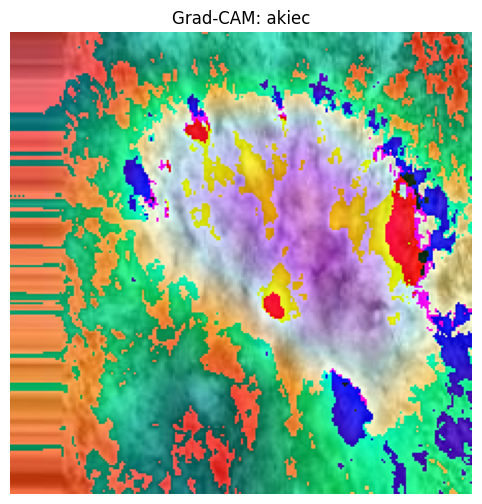

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
🔮 Predicted Class: akiec (Prob: 1.00)


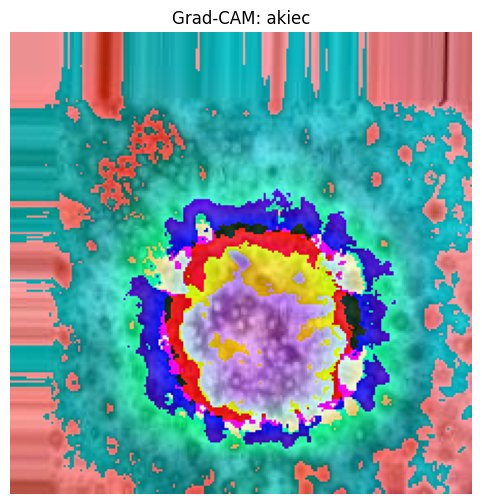

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
🔮 Predicted Class: vasc (Prob: 1.00)


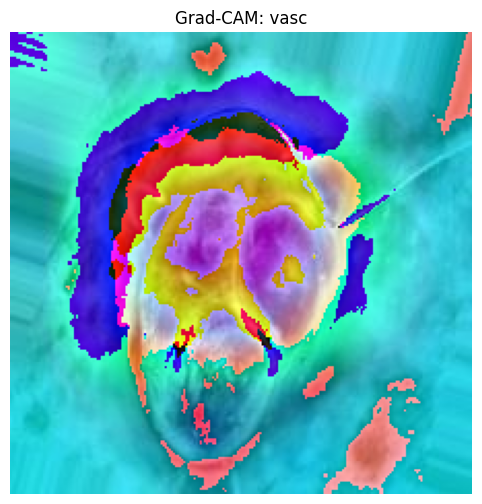

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
🔮 Predicted Class: df (Prob: 1.00)


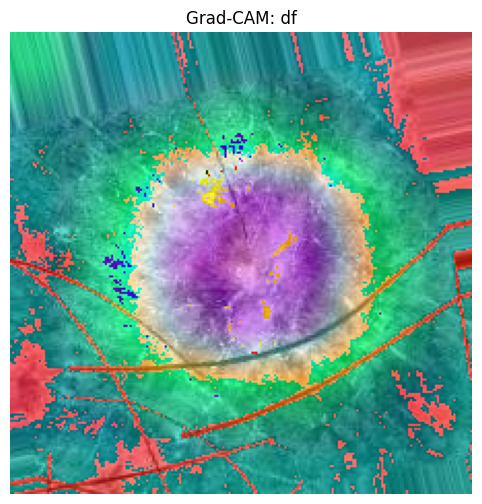

In [20]:
# Pick image filenames from validation dataframe
sample_imgs = val_df["filename"].sample(5, random_state=42).tolist()
image_dir = "/kaggle/working/balanced_data_augmented"  # path where images are stored
last_conv_layer = "conv5_block16_concat"     # DenseNet121 last conv block

for img_name in sample_imgs:
    full_path = os.path.join(image_dir, img_name)
    show_gradcam(full_path, model, last_conv_layer_name=last_conv_layer)


The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1289']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))


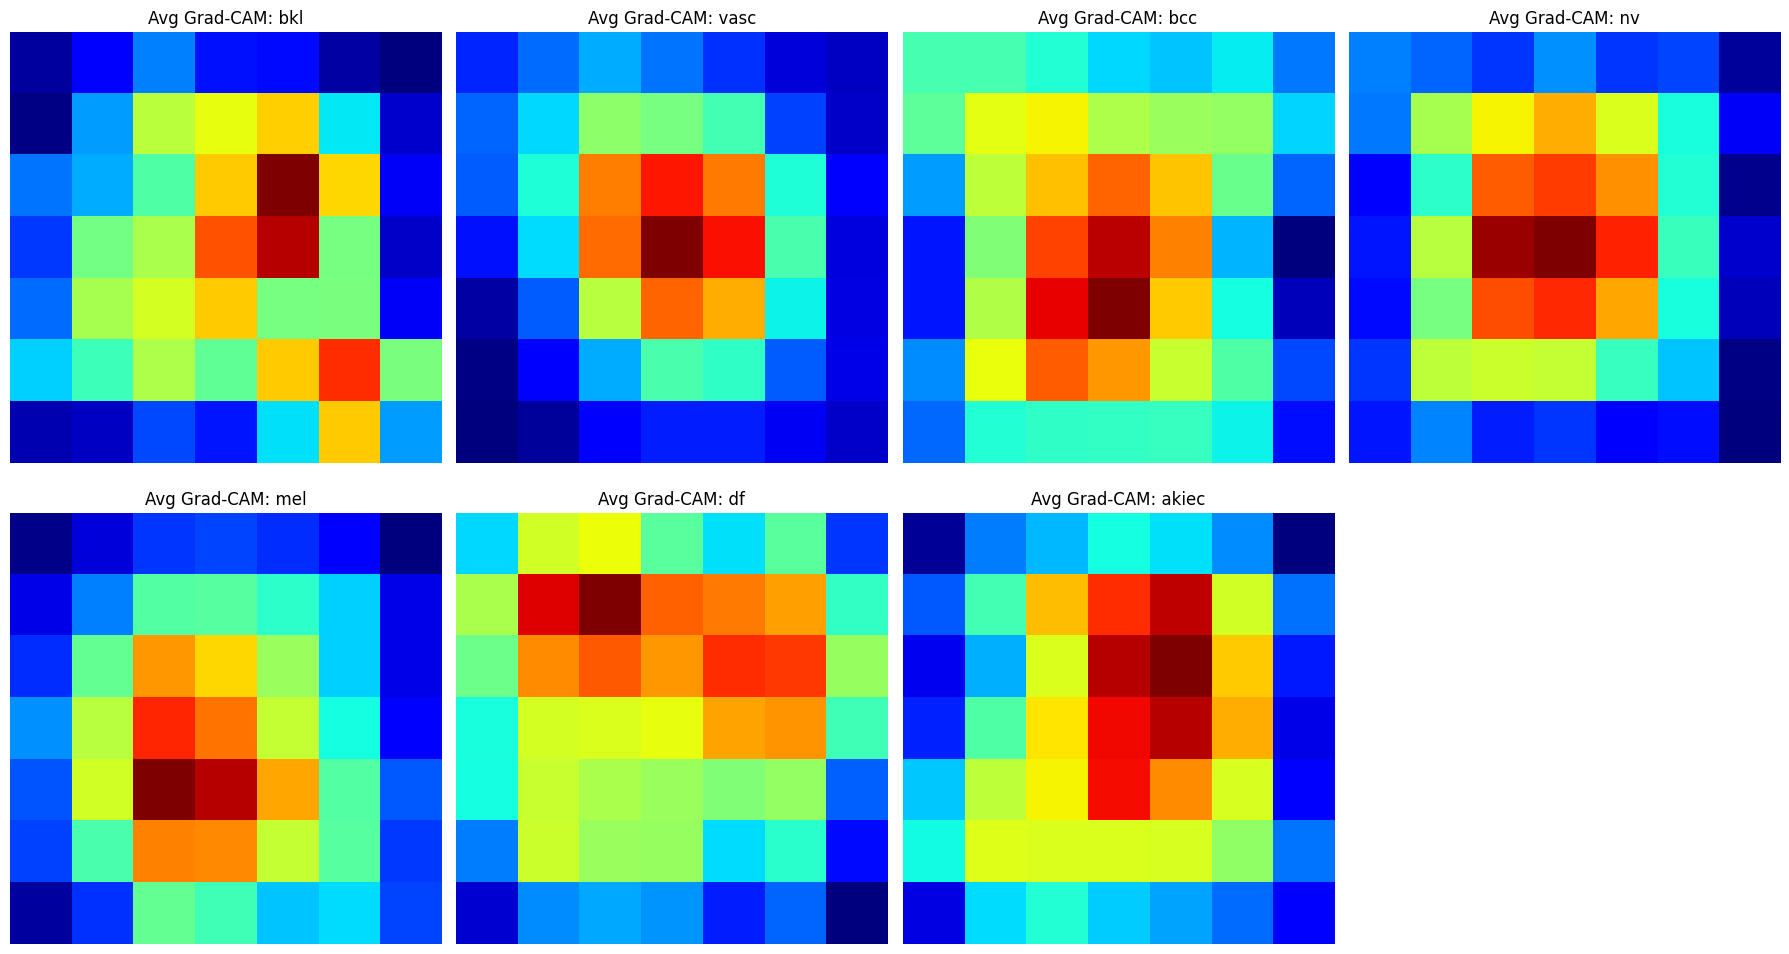

In [70]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def compute_average_gradcam(class_name, model, df, image_dir, conv_layer, num_samples=20):
    images = df[df['dx'] == class_name]['filename'].sample(n=num_samples, random_state=42)
    avg_heatmap = None
    
    for img_name in images:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=(224, 224))
        img_arr = img_to_array(img) / 255.0
        input_arr = np.expand_dims(img_arr, axis=0)

        heatmap = get_gradcam_heatmap(model, input_arr, conv_layer)

        if avg_heatmap is None:
            avg_heatmap = heatmap
        else:
            avg_heatmap += heatmap

    avg_heatmap /= num_samples
    return avg_heatmap

# === Compute and show for all classes ===
classes = val_df['dx'].unique()
image_dir = "/kaggle/working/balanced_data_augmented"
conv_layer = "conv5_block16_concat"

plt.figure(figsize=(18, 10))
for idx, class_name in enumerate(classes):
    avg_map = compute_average_gradcam(class_name, model, val_df, image_dir, conv_layer)
    plt.subplot(2, 4, idx+1)
    plt.imshow(avg_map, cmap='jet')
    plt.title(f"Avg Grad-CAM: {class_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.


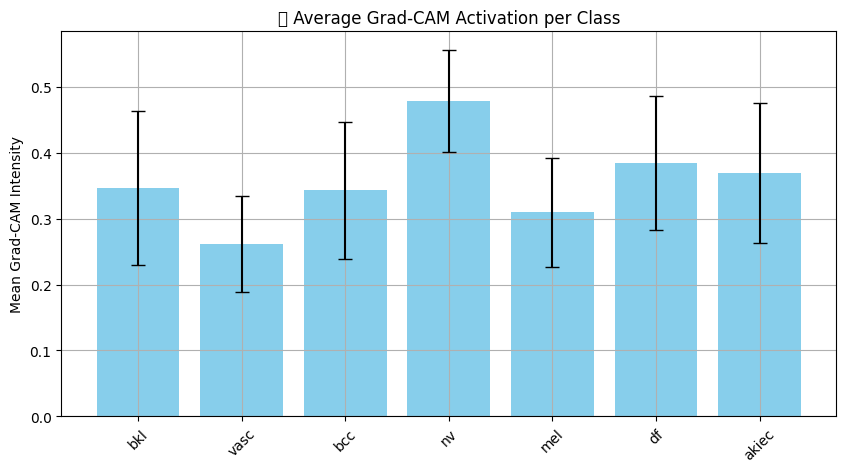

In [71]:
def gradcam_intensity_stats(class_name, model, df, image_dir, conv_layer, num_samples=20):
    images = df[df['dx'] == class_name]['filename'].sample(n=num_samples, random_state=42)
    mean_intensities = []
    
    for img_name in images:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=(224, 224))
        img_arr = img_to_array(img) / 255.0
        input_arr = np.expand_dims(img_arr, axis=0)

        heatmap = get_gradcam_heatmap(model, input_arr, conv_layer)
        mean_intensities.append(np.mean(heatmap))
    
    return np.mean(mean_intensities), np.std(mean_intensities)

# Collect per class
means, stds = [], []
for cls in classes:
    m, s = gradcam_intensity_stats(cls, model, val_df, image_dir, conv_layer)
    means.append(m)
    stds.append(s)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(classes, means, yerr=stds, color='skyblue', capsize=5)
plt.ylabel("Mean Grad-CAM Intensity")
plt.title("🔍 Average Grad-CAM Activation per Class")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


LIME

In [58]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np
import os


In [59]:
# Function that wraps model prediction to LIME format
def predict_fn(images):
    return model.predict(np.array(images))

# Preprocess function
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    return img_array


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.


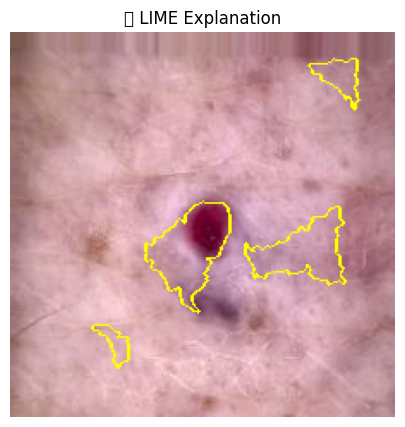

In [60]:
# Choose a random image from the validation dataframe
sample_img_name = val_df["filename"].sample(1, random_state=42).values[0]
sample_img_path = os.path.join(image_dir, sample_img_name)

# Preprocess image
img_array = preprocess_image(sample_img_path)

# Explain with LIME
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img_array.astype('double'),
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Show explanation
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(6, 5))
plt.imshow(mark_boundaries(temp, mask))
plt.title("🟢 LIME Explanation")
plt.axis('off')
plt.show()


In [62]:
import pandas as pd

# Expand dimension for batch shape (1, 224, 224, 3)
input_arr = np.expand_dims(img_array, axis=0)

# Predict class probabilities
preds = model.predict(input_arr)

# Map class names to probabilities
class_labels = list(train_gen.class_indices.keys())
prob_dict = {label: float(preds[0][i]) for i, label in enumerate(class_labels)}

# Display all class probabilities nicely
prob_df = pd.DataFrame(prob_dict.items(), columns=["Class", "Probability"]).sort_values(by="Probability", ascending=False)

print("🔮 Class Probabilities:")
display(prob_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
🔮 Class Probabilities:


Class  Probability
6   vasc     0.838269
1    bcc     0.124321
3     df     0.021931
4    mel     0.009077
2    bkl     0.002540
0  akiec     0.002297
5     nv     0.001565

In [72]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.densenet import preprocess_input

# Step 1: Explainer
explainer = lime_image.LimeImageExplainer()

# Step 2: Wrapper prediction function for LIME
def predict_fn(images):
    images = preprocess_input(images)  # Rescale to match DenseNet expectations
    return model.predict(images)


In [75]:
import random
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Helper to plot original + LIME mask
def explain_with_lime(img_path, model, explainer):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    input_img = np.expand_dims(img_array, axis=0)

    explanation = explainer.explain_instance(
        image=np.array(img_array),
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=8,
        hide_rest=False
    )

    # Plot original and LIME explanation
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(np.array(img).astype('uint8'))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title("LIME Explanation")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

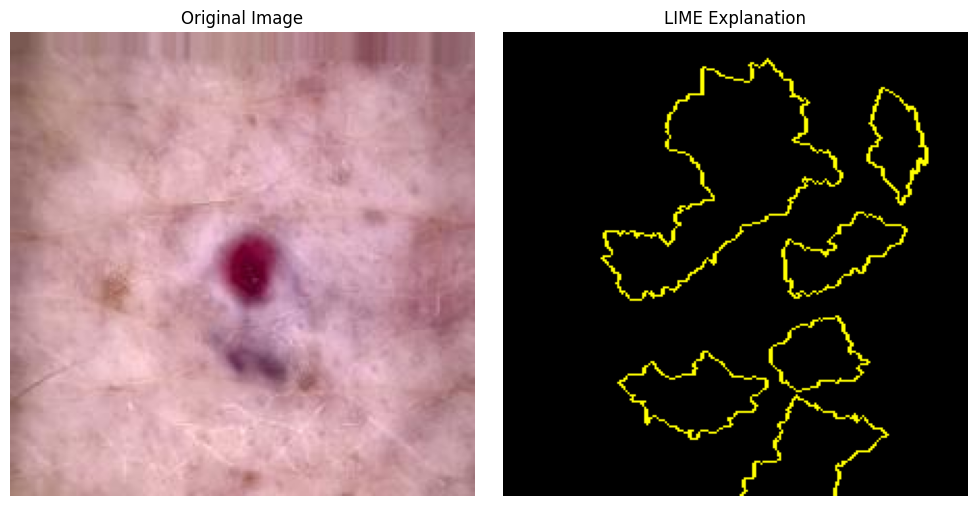

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

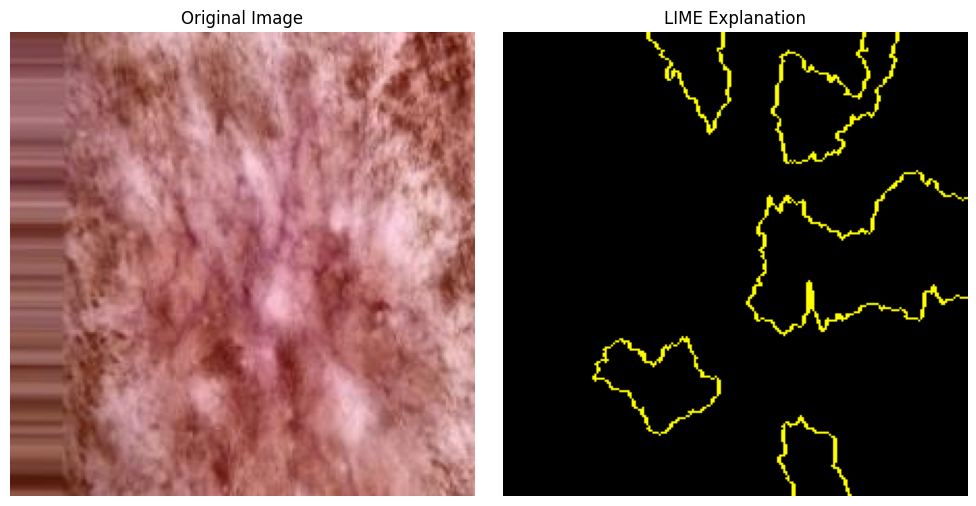

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

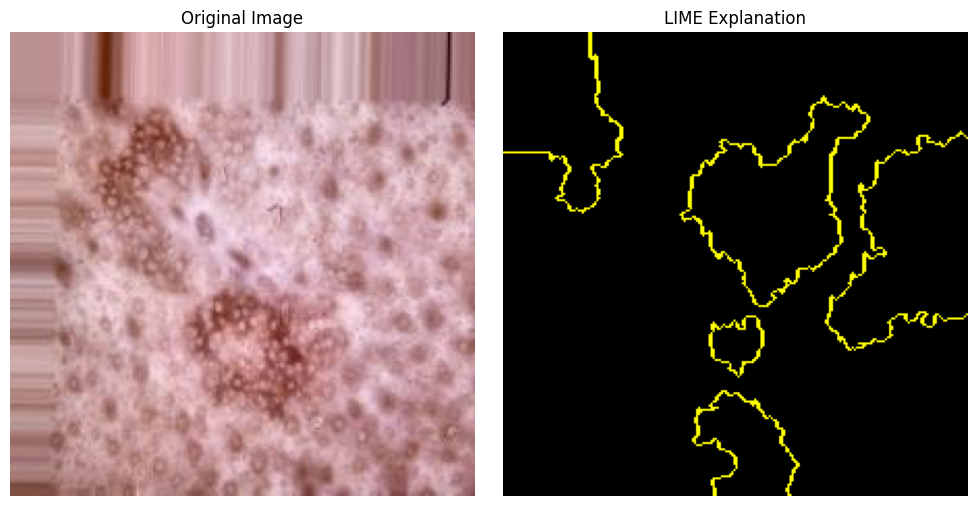

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

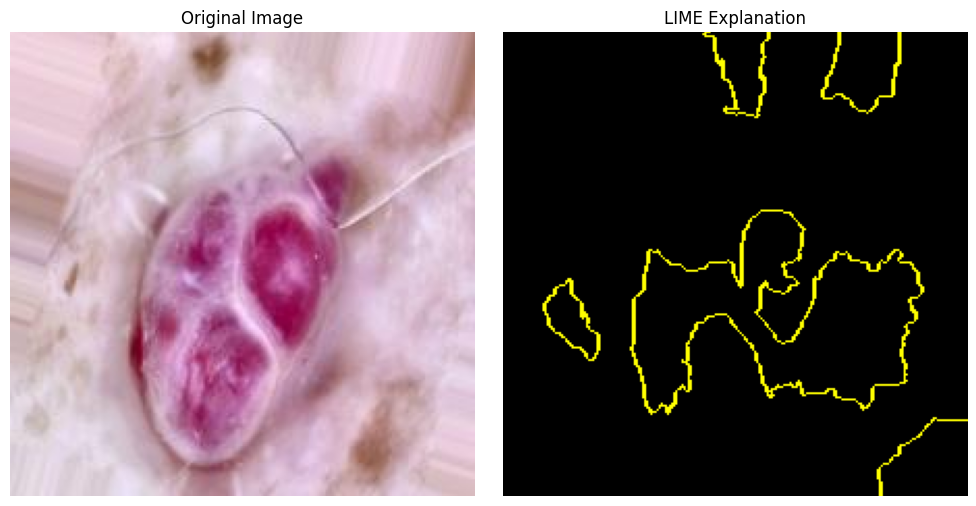

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

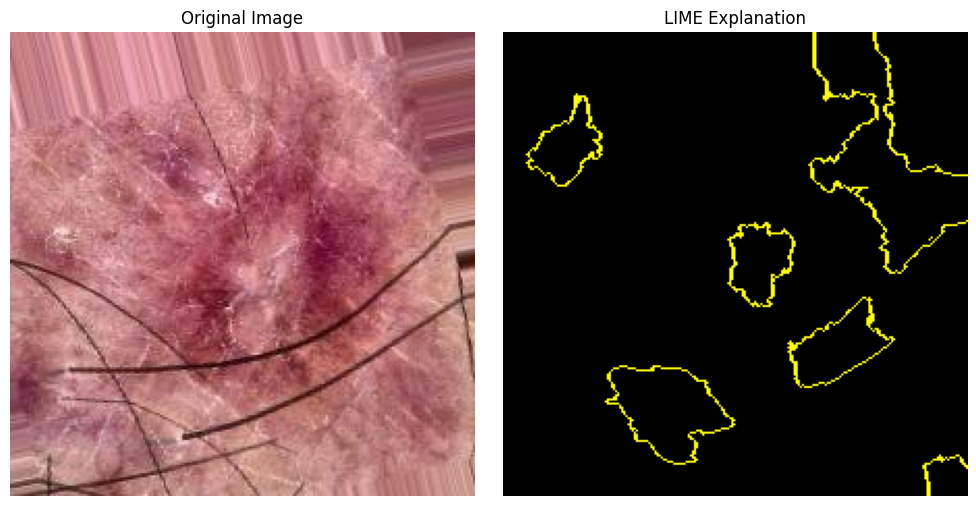

In [76]:
# Pick some samples
sample_imgs = val_df["filename"].sample(5, random_state=42).tolist()
image_dir = "/kaggle/working/balanced_data_augmented"  # Your image path

for img_name in sample_imgs:
    img_path = os.path.join(image_dir, img_name)
    explain_with_lime(img_path, model, explainer)


In [77]:
import pandas as pd

# Create empty list to hold results
lime_results = []

# Make sure the model & data are loaded
for img_name in sample_imgs:
    img_path = os.path.join(image_dir, img_name)
    
    # Load and preprocess
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    input_arr = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(input_arr)
    pred_class_index = np.argmax(preds[0])
    pred_label = list(train_gen.class_indices.keys())[pred_class_index]
    confidence = preds[0][pred_class_index]

    # Get ground truth label
    actual_label = val_df[val_df['filename'] == img_name]['dx'].values[0]

    # Append row
    lime_results.append({
        "Image": img_name,
        "Actual Label": actual_label,
        "Predicted Label": pred_label,
        "Confidence": round(confidence, 3)
    })

# Convert to DataFrame
lime_df = pd.DataFrame(lime_results)

# Display nicely
print("📋 LIME Sample Predictions Table")
display(lime_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
📋 LIME Sample Predictions Table


Image Actual Label Predicted Label  Confidence
0   vasc_aug_5762_ISIC_0033817.jpg         vasc            vasc       0.838
1  akiec_aug_1865_ISIC_0024470.jpg        akiec           akiec       0.350
2  akiec_aug_2447_ISIC_0030143.jpg        akiec           akiec       0.446
3   vasc_aug_4043_ISIC_0030722.jpg         vasc            vasc       0.828
4     df_aug_5842_ISIC_0026471.jpg           df              df       0.583

In [66]:
import shutil

shutil.make_archive("/kaggle/working/balanced_data_augmented", 'zip', "/kaggle/working/balanced_data_augmented")


'/kaggle/working/balanced_data_augmented.zip'

In [67]:
from IPython.display import FileLink

# Display download link
FileLink("/kaggle/working/balanced_data_augmented.zip")


/kaggle/working/balanced_data_augmented.zip

SHAP